# Module 2 Summative Lab

## Introduction

For today's section, we're going to work on a single big lab to apply everything we've learned in Mod 2!

## About This Lab

A quick note before getting started--this lab isn't like other labs you seen so far. This lab is meant to take ~8 hours to complete, so it's much longer and more challenging than the average labs you've seen so far. If you feel like this lab is challenging or that you might be struggling a bit, don't fret--that's by design! With everything we've learned about Web Scraping, APIs, and Databases, the best way to test our knowledge of it is to build something substantial! 

## The Project

In this lab, we're going to make use of everything we've learned about APIs, databases, and Object-Oriented Programming to **_Extract, Transform, and Load_** (or **_ETL_**, for short) some data from a SQL database into a MongoDB Database. 

You'll find a database containing information about soccer teams and the matches they've played in the file `database.sqlite`. For this project, our goal is to get the data we think is important from this SQL database, do some calculations and data transformation, and then store everything in a MongoDB database. 

Let's get into the specifics of this project.

### The Goal

Start by examining the data dictionary for the SQL database we'll be working with, which comes from this [kaggle page](https://www.kaggle.com/laudanum/footballdelphi).  Familiarize yourself with the tables it contains, and what each column means. We'll be using this database to get data on each soccer team, calculate some summary statistics, and then store each in a MongoDB database. 

Upon completion of this lab, each unique team in this dataset should have a record in the MongoDB instance containing the following information:

* The name of the team
* The total number of goals scored by the team during the 2011 season
* The total number of wins the team earned during the 2011 season
* A histogram visualization of the team's wins and losses for the 2011 season (store the visualization directly by assigning it to a variable)
* The team's win percentage on days where it was raining during games in the 2011 season. 

#### Getting the Weather Data

Note that for this last calculation, you'll need to figure out if it was raining or not during the game. The database itself does not contain this information, but it does contain the date on which the game was played. For this, you'll need to use the [DarkSky API](https://darksky.net/dev) to get the historical weather data for that day. Note that each game is played in a different location, and this information is not contained in our SQL database. However, the teams in this database are largely german, so go ahead and just use the weather in Berlin, Germany as a proxy for this information. If it was raining in Berlin on the day the game was played, count that as rain game--**_you do not need to try and figure out the actual weather at each game's location, because we don't have that information!_**

#### NOTE: The DarkSky API is limited to 1000 free API calls a day, so be sure to test your model on very small samples. Otherwise, you'll hit the rate limit!

## Project Architecture

Unlike previous labs, this lab is more open-ended, and will require you to make design decisions and plan out your strategy for building a system with this many working parts. However, **_using Object-Oriented Programming is a requirement for this project--you must create at least 2 separate, well-structured classes in your solution!_** Although it may seem easier to "just start coding", this is a classic beginner's mistake. Instead, think about separating out the different functionalities you'll need to reach your goal, and then build classes to handle each. For instance, at a minimum, you'll need to:

* Query the SQL database
* Calculate summary statistics
* Get the weather data from the DarkSky API
* Load the data into MongoDB

We **_strongly recommend_** you consider creating separate classes for handling at least some of these tasks.  Be sure to plan the inputs, outputs, and methods for each class before you begin coding! 

**_NOTE:_** We have provided some empty classes below. You are welcome to delete them and use a different architecture for this project if you so choose.  You do not have to use each of them, they are just there to give you an idea of what sorts of classes you may want to consider using.

### Rapid Prototyping and Refactoring

It's totally okay to try to get a task working without using OOP. For instance, when experimenting with the DarkSky API for getting historical weather data, it makes sense to just write the code in the cells and rapidly iterate until you get it all working. However, once you get it working, you're not done--you should then **_Refactor_** your code into functions or classes to make your code more modular, reusable, understandable, and maintainable! 

In short--do what you need to do to get each separate piece of functionality working, and then refactor it into a class after you've figured it out!

### Some Final Advice

You haven't built anything this big or complex thus far, so you may not yet fully realize how much trial and error goes into it. If your code keeps breaking, resist the urge to get frustrated, and just keep working. Software development is an iterative process!  No one writes perfect code that works the first time for something this involved. You're going to run into _a lot_ of small errors in this project, right up until the point where it just works, and then you're done! However, you can reduce these errors by planning out your code, and thinking about how all of the pieces fit together before you begin coding. Once you have some basic understanding of how it all will work, then you'll know what you need to build, and then all that is left is to build it!

In short:

* Plan ahead--you'll thank yourself later!
* Errors and broken code aren't bad, they're normal. 
* Keep working, and stay confident--you can do this!

Good luck--we look forward to seeing your completed project!

In [7]:
# First, let's figure out the weather API
import requests
import json

class WeatherGetter(object):
    
    def __init__(self):
        self.secret_key = "ead9b0d3323ae9258b916a91b701c722"
        self.berlin_lat = "52.5200"
        self.berlin_long = "13.4050"
        self.url_base = "https://api.darksky.net/forecast"
        self.exclude = 'currently,flags,minutely,hourly,alerts'
        
    def get_weather_data_for_date(self, datetime_string, verbose=True):
        
        year, month, day = self.format_datetime(datetime_string)
        
        datetime = "{}-{}-{}T12:00:00".format(year, month, day)
        full_url = "{}/{}/{},{},{}?exclude={}".format(self.url_base, self.secret_key, 
                                                     self.berlin_lat, self.berlin_long, 
                                                     datetime, self.exclude)
        response = requests.get(full_url)
        if response.status_code == 200:
            if verbose:
                print(response.status_code, full_url)
            return response
        else: 
            raise ValueError("Error getting data from DarkSky API: Response Code {}".format(response.status_code), full_url)
            
    def was_raining(self, response, verbose=True):
        data = json.loads(response.text)
        daily = data['daily']
        data =  daily['data']
        data = data[0]
        if 'icon' in data.keys():
            if data['icon'] == 'rain':
                if verbose:
                    print('rain')
                return True
            else:
                if verbose:
                    print(data['icon'])
                return False
        else:
            print('no icon')
    
    def format_datetime(self, datetime_string):
        year = datetime_string[:4]
        month = datetime_string[5:7]
        day = datetime_string[8:]
        
        return year, month, day
    
    def did_rain_on_date(self, datetime_string):
        
        response = self.get_weather_data_for_date(datetime_string, verbose=False)
        did_rain = self.was_raining(response, verbose=False)
        
        return did_rain
    
    def get_weather_for_all_dates(self, dates_list):    
        weather_dict = {}
        
        for date in dates_list:
            weather_dict[date] = self.did_rain_on_date(date)
        
        return weather_dict

In [2]:
# let's check out what the request is actually returning

my_request = 'https://api.darksky.net/forecast/ead9b0d3323ae9258b916a91b701c722/52.5200,13.4050'
response = requests.get(my_request)
response.text
# WOW that's a wall of text

'{"latitude":52.52,"longitude":13.405,"timezone":"Europe/Berlin","currently":{"time":1573678831,"summary":"Overcast","icon":"cloudy","precipIntensity":0,"precipProbability":0,"temperature":38.16,"apparentTemperature":33.57,"dewPoint":34.44,"humidity":0.86,"pressure":1004.2,"windSpeed":5.99,"windGust":13.51,"windBearing":192,"cloudCover":1,"uvIndex":0,"visibility":6.219,"ozone":299.8},"hourly":{"summary":"Clear throughout the day.","icon":"clear-day","data":[{"time":1573678800,"summary":"Overcast","icon":"cloudy","precipIntensity":0,"precipProbability":0,"temperature":38.16,"apparentTemperature":33.58,"dewPoint":34.44,"humidity":0.86,"pressure":1004.1,"windSpeed":5.99,"windGust":13.52,"windBearing":192,"cloudCover":1,"uvIndex":0,"visibility":6.216,"ozone":299.8},{"time":1573682400,"summary":"Overcast","icon":"cloudy","precipIntensity":0,"precipProbability":0,"temperature":37.86,"apparentTemperature":33.37,"dewPoint":34.51,"humidity":0.88,"pressure":1004.2,"windSpeed":5.77,"windGust":12.

In [3]:
response.json().keys()

dict_keys(['latitude', 'longitude', 'timezone', 'currently', 'hourly', 'daily', 'flags', 'offset'])

In [4]:
response.json()['daily']
# confirming that we want to be looking at the 'daily' information

{'summary': 'Light rain on Saturday through next Wednesday.',
 'icon': 'rain',
 'data': [{'time': 1573599600,
   'summary': 'Overcast throughout the day.',
   'icon': 'cloudy',
   'sunriseTime': 1573626360,
   'sunsetTime': 1573658280,
   'moonPhase': 0.54,
   'precipIntensity': 0.0001,
   'precipIntensityMax': 0.0004,
   'precipIntensityMaxTime': 1573601580,
   'precipProbability': 0.18,
   'precipType': 'rain',
   'temperatureHigh': 45.45,
   'temperatureHighTime': 1573652880,
   'temperatureLow': 36.77,
   'temperatureLowTime': 1573712700,
   'apparentTemperatureHigh': 41.79,
   'apparentTemperatureHighTime': 1573653540,
   'apparentTemperatureLow': 33.35,
   'apparentTemperatureLowTime': 1573681680,
   'dewPoint': 36.19,
   'humidity': 0.83,
   'pressure': 1003.7,
   'windSpeed': 6.93,
   'windGust': 15.44,
   'windGustTime': 1573667940,
   'windBearing': 171,
   'cloudCover': 0.85,
   'uvIndex': 1,
   'uvIndexTime': 1573640580,
   'visibility': 6.643,
   'ozone': 306.8,
   'temper

In [5]:
# looks great! 'icon' is where the rain/no rain binary will come from

data = json.loads(response.text)
daily = data['daily']
data =  daily['data']
data = data[0]
print(data)
print(data['icon'])

{'time': 1573599600, 'summary': 'Overcast throughout the day.', 'icon': 'cloudy', 'sunriseTime': 1573626360, 'sunsetTime': 1573658280, 'moonPhase': 0.54, 'precipIntensity': 0.0001, 'precipIntensityMax': 0.0004, 'precipIntensityMaxTime': 1573601580, 'precipProbability': 0.18, 'precipType': 'rain', 'temperatureHigh': 45.45, 'temperatureHighTime': 1573652880, 'temperatureLow': 36.77, 'temperatureLowTime': 1573712700, 'apparentTemperatureHigh': 41.79, 'apparentTemperatureHighTime': 1573653540, 'apparentTemperatureLow': 33.35, 'apparentTemperatureLowTime': 1573681680, 'dewPoint': 36.19, 'humidity': 0.83, 'pressure': 1003.7, 'windSpeed': 6.93, 'windGust': 15.44, 'windGustTime': 1573667940, 'windBearing': 171, 'cloudCover': 0.85, 'uvIndex': 1, 'uvIndexTime': 1573640580, 'visibility': 6.643, 'ozone': 306.8, 'temperatureMin': 37.36, 'temperatureMinTime': 1573682640, 'temperatureMax': 45.45, 'temperatureMaxTime': 1573652880, 'apparentTemperatureMin': 33.35, 'apparentTemperatureMinTime': 15736816

In [8]:
# WeatherGetter test
wg = WeatherGetter()
print(wg.did_rain_on_date('2019-09-11')) # that's my birthday
print(wg.did_rain_on_date('2019-11-09')) # this is a recent day that rained

False
True


In [9]:
# Cool, that's working! Next:
# Get matches for 2011
# will eventually add column for "raining?"
import sqlite3
import pandas as pd
import numpy as np

conn = sqlite3.connect('''database.sqlite''')
cur = conn.cursor()

In [10]:
# all info in table for matches in 2011
cur.execute('''select * from matches where season = 2011''')

matches = pd.DataFrame(cur.fetchall())
matches.columns = [i[0] for i in cur.description]
matches.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D


In [11]:
# now I'm grabbing unique dates, so I don't max out the API
unique_dates = matches.Date.unique()
print("# of Unique Game Dates in 2011 Season: {}".format(len(unique_dates)))
print(unique_dates)
# it's weird that you could have a game in the 2011 season and in year 2012, but I don't decide that...

# of Unique Game Dates in 2011 Season: 165
['2012-03-31' '2011-12-11' '2011-08-13' '2011-11-27' '2012-02-18'
 '2012-01-20' '2012-02-04' '2012-04-21' '2011-09-18' '2011-10-23'
 '2011-10-01' '2012-03-03' '2011-08-27' '2012-03-17' '2011-11-06'
 '2012-05-05' '2012-04-11' '2011-12-17' '2012-02-03' '2011-10-29'
 '2012-01-22' '2011-12-03' '2012-04-14' '2012-03-25' '2012-03-10'
 '2012-04-07' '2011-11-19' '2011-10-14' '2011-09-24' '2012-04-28'
 '2011-12-18' '2012-03-02' '2012-03-16' '2012-02-17' '2011-08-06'
 '2011-11-04' '2011-09-16' '2011-07-15' '2012-05-06' '2012-02-11'
 '2011-10-02' '2012-03-30' '2011-10-22' '2011-08-26' '2011-08-07'
 '2012-02-24' '2011-07-17' '2012-02-12' '2011-08-22' '2011-09-09'
 '2012-04-01' '2011-09-25' '2012-04-20' '2011-11-25' '2012-03-09'
 '2011-11-07' '2011-09-10' '2011-08-21' '2011-09-26' '2012-03-26'
 '2011-10-30' '2012-02-13' '2012-02-26' '2011-12-19' '2012-03-11'
 '2011-11-26' '2012-04-23' '2011-12-16' '2011-11-05' '2012-04-10'
 '2012-04-15' '2012-02-05' '2012-

In [12]:
# Let's combine our match info and the rain info
rain_dates = wg.get_weather_for_all_dates(unique_dates)

no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon
no icon


{'2012-03-31': True,
 '2011-12-11': False,
 '2011-08-13': False,
 '2011-11-27': False,
 '2012-02-18': False,
 '2012-01-20': True,
 '2012-02-04': False,
 '2012-04-21': False,
 '2011-09-18': True,
 '2011-10-23': True,
 '2011-10-01': None,
 '2012-03-03': None,
 '2011-08-27': True,
 '2012-03-17': None,
 '2011-11-06': True,
 '2012-05-05': True,
 '2012-04-11': False,
 '2011-12-17': True,
 '2012-02-03': False,
 '2011-10-29': None,
 '2012-01-22': True,
 '2011-12-03': True,
 '2012-04-14': None,
 '2012-03-25': False,
 '2012-03-10': False,
 '2012-04-07': False,
 '2011-11-19': False,
 '2011-10-14': None,
 '2011-09-24': None,
 '2012-04-28': None,
 '2011-12-18': True,
 '2012-03-02': False,
 '2012-03-16': None,
 '2012-02-17': True,
 '2011-08-06': True,
 '2011-11-04': None,
 '2011-09-16': False,
 '2011-07-15': False,
 '2012-05-06': True,
 '2012-02-11': False,
 '2011-10-02': None,
 '2012-03-30': False,
 '2011-10-22': None,
 '2011-08-26': True,
 '2011-08-07': True,
 '2012-02-24': True,
 '2011-07-17': Tr

In [13]:
# create boolean column for a rain game
rain_game = []
for date in matches.Date:
    rain_game.append(rain_dates[date])

matches['Rain_Game'] = rain_game
matches

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Rain_Game
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A,True
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A,False
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A,False
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H,False
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D,False
5,1097,D1,2011,2012-01-20,M'gladbach,Bayern Munich,3,1,H,True
6,1098,D1,2011,2012-02-04,Hamburg,Bayern Munich,1,1,D,False
7,1099,D1,2011,2012-04-21,Werder Bremen,Bayern Munich,1,2,A,False
8,1100,D1,2011,2011-09-18,Schalke 04,Bayern Munich,0,2,A,True
9,1101,D1,2011,2011-10-23,Hannover,Bayern Munich,2,1,H,True


In [14]:
# we don't need to update our dataframe; we just need a count of games won in the rain
# let's create a dictionary and iterate through
all_teams = matches['HomeTeam'].unique()
print("# of Unique Teams: {}".format(len(all_teams)))

teams_data = {}
for team in all_teams:
    data = {'total_matches_2011': 0, 
           'total_wins_2011': 0,
           'total_losses_2011': 0,
           'rain_wins_2011': 0,
           'rain_losses_2011': 0,
           'total_goals_2011': 0}
    teams_data[team] = data
print(len(teams_data))

# of Unique Teams: 56
56


In [15]:
def update_team_data(row):
  
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    home_goals = row['FTHG']
    away_goals = row['FTAG']
    datetime = row['Date']
    year = datetime[:4]
    home_did_win = False
    away_did_win = False
    
    is_rain_game = row['Rain_Game']
    
    # Determine Winner and Loser of Match
    if row['FTR'] == 'H':            
        home_did_win = True
        away_did_win = False
    elif row['FTR'] == 'A':
        home_did_win = False
        away_did_win = True
    else:
        home_did_win = False
        away_did_win = False
    
    # Update records for home team
    update_team_win_loss_record(home_team, home_goals, home_did_win, year, is_rain_game)
    
    # Update records for away team
    update_team_win_loss_record(away_team, away_goals, away_did_win, year, is_rain_game)
    
def update_team_win_loss_record(team_name, goals, did_win, year, is_rain_game):
    team = teams_data[team_name]
    team['total_matches_2011'] += 1
    if did_win == True:
        team['total_wins_2011'] += 1
        if is_rain_game == True:
            team['rain_wins_2011'] += 1
    else:
        team['total_losses_2011'] += 1
        team['rain_losses_2011'] += 1
    team['total_goals_2011'] += goals

In [16]:
# let's see what it looks like
matches.apply(update_team_data, axis=1)
print(teams_data)

{'Nurnberg': {'total_matches_2011': 34, 'total_wins_2011': 12, 'total_losses_2011': 22, 'rain_wins_2011': 5, 'rain_losses_2011': 22, 'total_goals_2011': 38}, 'Stuttgart': {'total_matches_2011': 34, 'total_wins_2011': 15, 'total_losses_2011': 19, 'rain_wins_2011': 3, 'rain_losses_2011': 19, 'total_goals_2011': 63}, 'Wolfsburg': {'total_matches_2011': 34, 'total_wins_2011': 13, 'total_losses_2011': 21, 'rain_wins_2011': 4, 'rain_losses_2011': 21, 'total_goals_2011': 47}, 'Mainz': {'total_matches_2011': 34, 'total_wins_2011': 9, 'total_losses_2011': 25, 'rain_wins_2011': 2, 'rain_losses_2011': 25, 'total_goals_2011': 47}, 'Freiburg': {'total_matches_2011': 34, 'total_wins_2011': 10, 'total_losses_2011': 24, 'rain_wins_2011': 3, 'rain_losses_2011': 24, 'total_goals_2011': 45}, "M'gladbach": {'total_matches_2011': 34, 'total_wins_2011': 17, 'total_losses_2011': 17, 'rain_wins_2011': 8, 'rain_losses_2011': 17, 'total_goals_2011': 49}, 'Hamburg': {'total_matches_2011': 34, 'total_wins_2011': 

In [20]:
# Add to MongoDB
import pymongo

class MongodbHandler(object):
    #handler seems like a funny name but let's go with it
    
    def __init__(self):
        self.myclient = pymongo.MongoClient('mongodb://localhost:27017')
        self.db = self.myclient['section_16_lab_db']
        self.coll = self.db['section_16_lab_collection']
    
    def format_data(self, team_name, goals_2011, wins_2011, viz, rain_win_pct):
        data = {"team_name": team_name,
               "goals_2011": goals_2011,
               "wins_2011": wins_2011,
               "win_loss_histogram": viz,
               "rain_win_pct": rain_win_pct}
        
        return data
    
    def insert_record(self, record):
        
        return self.coll.insert_one(data)

12
22
([array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), array([0., 0

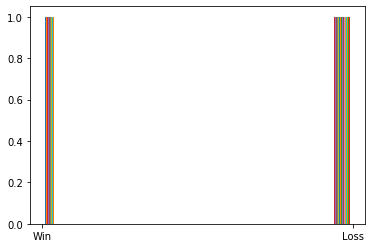

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

def get_hist(team, show_viz=False):
    expanded_wl_data = []
    print(team['total_wins_2011'])
    print(team['total_losses_2011'])
    for i in range(team['total_wins_2011']):
        expanded_wl_data.append('Win')
    for i in range(team['total_losses_2011']):
        expanded_wl_data.append('Loss')
    hist = plt.hist(expanded_wl_data)
    
    if show_viz:
        plt.show()
    
    return hist

print(get_hist(teams_data['Nurnberg']))

12
22


DuplicateKeyError: E11000 duplicate key error collection: section_16_lab_db.section_16_lab_collection index: _id_ dup key: { : ObjectId('5dcc6fa17c5510f34c816a7e') }

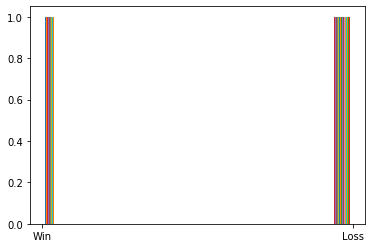

In [22]:
db = MongodbHandler()

for team_name, data in teams_data.items():
    if data['rain_wins_2011'] == 0 and data['rain_losses_2011'] == 0:
        rain_win_pct = "N/A"
    else:
        total_rain_games = data['rain_wins_2011'] + data['rain_losses_2011']
        rain_win_pct = str(data['rain_wins_2011'] / total_rain_games)
    
    viz = get_hist(data)
    
    record = db.format_data(team_name, data['total_goals_2011'], data['total_wins_2011'], viz, rain_win_pct)
    db.insert_record(record)
    
    del(viz)

# Summary

In this lab, we dug deep and used everything we've learned so far about python programming, databases, HTTP requests and API calls to ETL data from a SQL database into a MongoDB instance!